In [1]:
# %load ~/junk/firstcell
%matplotlib inline
# %reload_ext autoreload
# %autoreload 2

import json, glob, sys, os, gzip, time
from IPython.display import HTML
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm
import requests



/cms/base/Miniconda/miniconda/lib/python3.7/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patheffects as meffects

class DoubleBandObject(object): pass
class DoubleBandObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0-height*0.25], width, height*1.5, facecolor="yellow",
                                   edgecolor="none", lw=0.,
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        patch = mpatches.Rectangle([x0, y0+0.25*height*1.5-height*0.25], width, height*1.5*0.5, facecolor="green",
                                   edgecolor="none", lw=0.,
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        patch = mlines.Line2D(
                [x0+width*0.03,x0+width-width*0.03],[y0-height*0.25+height*0.75],color=(0.,0.,0.),linewidth=1,linestyle="--",
                transform=handlebox.get_transform(),
                )
        handlebox.add_artist(patch)
        return patch

In [3]:
def smooth_(df):
    df = df.sort_index()
    spikes = []
    mzs = []
    window = 3 # times 1%*mass
    nsigma = 1.5 # if |br - median(window-except-central)|/std(window-except-central) > nsigma, then filter out
    for column in df.columns:
        s = df[column]
        for m in s.index.values:
            v = s[(s.index > m*(1-window*0.01)) & (s.index < m*(1+window*0.01))]
            br = v[v.index == m].iloc[0]
            v = v[v.index != m]
            v = v[v/v.median() < 20] # exclude points that are 50x the median
            z = (br-v.median())/v.std()
            mzs.append([m, z])
    mzs = np.array(mzs)
    spikes = mzs[:,0][np.abs(mzs[:,1]) > nsigma].tolist()
    return df.iloc[~df.index.isin(spikes)]

mask_ranges = np.array([
    [0.43,0.49],
    [0.52,0.58],
    [0.73,0.84],
    [0.96,1.08],
    [2.91,3.27],
    [3.47,3.89],
    [8.99,9.87],
    [9.61,10.77],
    ])
mask_ranges[:,0] = mask_ranges[:,0]/(1+0.05)
mask_ranges[:,1] = mask_ranges[:,1]/(1-0.05)

In [4]:
# !scp ucsd:/home/users/namin/2019/scouting/repo/hardik_limits/displacedscouting_fitscountlimits/NevtUL_v0.csv .

In [4]:
dfc = pd.read_csv("limits_csvs/hzdlimits_alldata_ctau1_10_100_analysisDP_v1.csv")
#droppedmasses = [2.3,2.32,2.34,2.36,2.38,2.40,2.42,2.44,2.46,2.48,2.5,2.54,2.56,2.58,2.6,2.62,2.64,2.66,2.68,2.70,2.72,2.74,2.76,2.78, 4.4, 4.44, 4.48, 4.52, 4.56, 4.6, 4.64, 4.68, 4.72, 12]
# droppedmasses = [2.3,2.32,2.34,2.36,2.38,2.40,2.42,2.44,2.46,2.48,2.5,2.52,2.54,2.56,2.58,2.6,2.62,2.64,2.66,2.68,2.70,2.72,2.74,2.76,2.78,2.8, 4.12, 4.16, 4.2, 4.24, 4.28, 4.32, 4.36, 4.4, 4.44, 4.48, 4.52, 4.56, 4.6, 4.64, 4.68, 4.72, 12]
droppedmasses = []
dfc = dfc[~(dfc.mass.isin(droppedmasses))]
dfc
# dfc1 = pd.read_csv("hzdlimits_alldata_ctau1_10_50_100_modifiedmodifiedDP_v1.csv")
# droppedmasses = []
# dfc1 = dfc1[~(dfc1.mass.isin(droppedmasses))]
# dfc = dfc.append(dfc1)
# dfc

,mass,ctau = 1,ctau = 10,ctau = 100,what
0,0.61,9.155965e+00,3.075297e+01,3.294680e+02,xsecBRbrUL
1,0.61,3.368132e+01,2.490770e+01,2.855754e+01,nevtUL
2,0.61,5.490690e+01,4.265893e+01,5.060722e+01,nevtULup
3,0.61,2.142531e+01,1.535242e+01,1.721159e+01,nevtULdown
4,0.61,9.074890e+01,7.208440e+01,8.670019e+01,nevtULupup
...,...,...,...,...,...
5185,25.00,6.193814e-06,3.147677e-06,7.310737e-06,BRbrULupup
5186,25.00,6.092276e-07,3.046139e-07,7.107661e-07,BRbrULdowndown
5187,25.00,2.335372e-06,1.116918e-06,2.538450e-06,BRbrULobs
5188,25.00,-8.497060e-02,-9.512810e-02,-5.651630e-02,Significance


In [10]:
droppedmasses = []
# droppedmasses.extend([0.885,0.89,0.895])
dfc = dfc[~(dfc.mass.isin(droppedmasses))]



df = dfc.set_index("mass")[["ctau = 100","what"]].pivot(columns="what").droplevel(0, axis=1)
df = smooth_(df[[
    "BRbrUL",
    "BRbrULup",
    "BRbrULupup",
    "BRbrULdown",
    "BRbrULdowndown",
    "BRbrULobs",
    "Significance",
    "posSignificance"
]])
#df

# df.to_csv("HZdZd_2mu_smoothed_ctau100mm_vf2.csv")


NameError: name 'ax2' is not defined

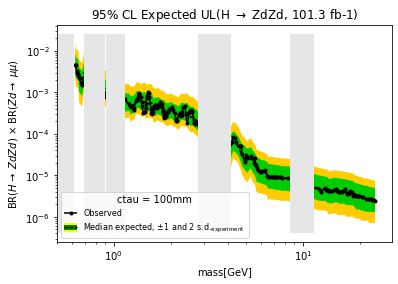

In [11]:
import matplotlib.gridspec as gridspec

fig, ax1 = plt.subplots()

ms = df.index
exp = df["BRbrUL"]
obs = df["BRbrULobs"]
sp1 = df["BRbrULup"]
sp2 = df["BRbrULupup"]
sm1 = df["BRbrULdown"]
sm2 = df["BRbrULdowndown"]
sig = df["Significance"]

pe2 = ax1.fill_between(ms, sm2, sp2, linewidth=0., facecolor=(1,0.8,0), alpha=1.0, zorder=1)
pe1 = ax1.fill_between(ms, sm1, sp1, linewidth=0., facecolor=(0,0.8,0), alpha=1.0, zorder=1)
pe0 = ax1.plot(ms, exp, linestyle="--", marker="",color="k",solid_capstyle="butt", zorder=1)
pobs = ax1.plot(ms, obs, linestyle="-", markersize=3.,marker="o",color="k",solid_capstyle="butt", zorder=1)

legend = ax1.legend([(pobs[0],),DoubleBandObject()],
        ["Observed",r"Median expected, $\pm$1 and 2 s.d.${}_\mathrm{experiment}$"],
        handler_map={DoubleBandObject: DoubleBandObjectHandler()},
        labelspacing=0.5,
        fontsize=8,
        handlelength=1.6,
        title="ctau = 100mm",
        loc = "lower left"
        )


ax1.set_yscale("log")
ylim = ax1.get_ylim()
for low,high in mask_ranges:
    ax1.fill_betweenx(ylim, low, high, color="0.9", zorder=2)
#ax.set_ylim(ylim)
#ax1.set_ylim(1e-7,5e-1)
ax1.set_xscale("log")

ax1.set_xlabel('mass[GeV]')
ax1.set_ylabel(r'BR($H \rightarrow$ $ZdZd$) $\times$ BR($Zd \rightarrow$ $\mu\mu$)')
ax1.set_title(r"95$\%$ CL Expected UL(H $\rightarrow$ ZdZd, 101.3 fb-1)")


ax1.set_xlim(left=0.5)
#ax1.set_xlim(1.0,2.3)

ax2.plot(ms, sig, linestyle="--", marker="",color="red",solid_capstyle="butt", zorder=1)
ax2.set_xscale("log")
ax2.set_xlim(left=0.5)
#ax2.set_xlim(1.0,2.3)
ax2.set_ylim(-2.5,2.5)

ax2.set_xlabel('mass[GeV]')
ax2.set_ylabel("Significance", labelpad = 10)

fig.savefig("HZdZd_ctau1mm.png")

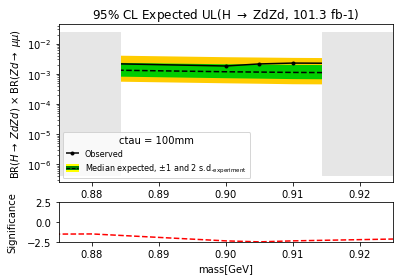

In [7]:
import matplotlib.gridspec as gridspec

fig, (ax1,ax2) = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [4, 1]})

ms = df.index
exp = df["BRbrUL"]
obs = df["BRbrULobs"]
sp1 = df["BRbrULup"]
sp2 = df["BRbrULupup"]
sm1 = df["BRbrULdown"]
sm2 = df["BRbrULdowndown"]
sig = df["Significance"]

pe2 = ax1.fill_between(ms, sm2, sp2, linewidth=0., facecolor=(1,0.8,0), alpha=1.0, zorder=1)
pe1 = ax1.fill_between(ms, sm1, sp1, linewidth=0., facecolor=(0,0.8,0), alpha=1.0, zorder=1)
pe0 = ax1.plot(ms, exp, linestyle="--", marker="",color="k",solid_capstyle="butt", zorder=1)
pobs = ax1.plot(ms, obs, linestyle="-", markersize=3.,marker="o",color="k",solid_capstyle="butt", zorder=1)

legend = ax1.legend([(pobs[0],),DoubleBandObject()],
        ["Observed",r"Median expected, $\pm$1 and 2 s.d.${}_\mathrm{experiment}$"],
        handler_map={DoubleBandObject: DoubleBandObjectHandler()},
        labelspacing=0.5,
        fontsize=8,
        handlelength=1.6,
        title="ctau = 100mm",
        loc = "lower left"
        )


ax1.set_yscale("log")
ylim = ax1.get_ylim()
for low,high in mask_ranges:
    ax1.fill_betweenx(ylim, low, high, color="0.9", zorder=2)
#ax.set_ylim(ylim)
#ax1.set_ylim(1e-7,5e-1)
#ax1.set_xscale("log")

ax1.set_xlabel('mass[GeV]')
ax1.set_ylabel(r'BR($H \rightarrow$ $ZdZd$) $\times$ BR($Zd \rightarrow$ $\mu\mu$)')
ax1.set_title(r"95$\%$ CL Expected UL(H $\rightarrow$ ZdZd, 101.3 fb-1)")


ax1.set_xlim(left=0.5)
ax1.set_xlim(0.875,0.925)

ax2.plot(ms, sig, linestyle="--", marker="",color="red",solid_capstyle="butt", zorder=1)
#ax2.set_xscale("log")
ax2.set_xlim(left=0.5)
ax2.set_xlim(0.875,0.925)
ax2.set_ylim(-2.5,2.5)

ax2.set_xlabel('mass[GeV]')
ax2.set_ylabel("Significance", labelpad = 10)

fig.savefig("HZdZd_ctau1mm.png")

In [11]:
dfc1 = pd.read_csv("limits_csvs/hzdlimits_alldata_m1_2p3_ctau1_10_100_analysisDP_v0.csv")
df1 = dfc1.set_index("mass")[["ctau = 1","what"]].pivot(columns="what").droplevel(0, axis=1)
df1 = smooth_(df1[[
    "BRbrUL",
    "BRbrULup",
    "BRbrULupup",
    "BRbrULdown",
    "BRbrULdowndown",
    "BRbrULobs",
    "Significance",
    "posSignificance"
]])

NameError: name 'ax2' is not defined

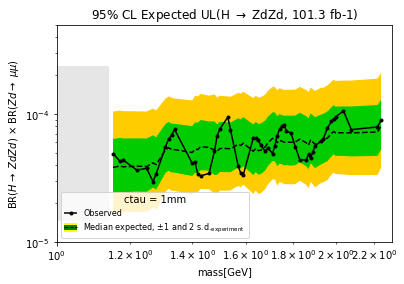

In [18]:
import matplotlib.gridspec as gridspec

fig, ax1 = plt.subplots()

ms = df1.index
exp = df1["BRbrUL"]
obs = df1["BRbrULobs"]
sp1 = df1["BRbrULup"]
sp2 = df1["BRbrULupup"]
sm1 = df1["BRbrULdown"]
sm2 = df1["BRbrULdowndown"]
sig = df1["Significance"]

pe2 = ax1.fill_between(ms, sm2, sp2, linewidth=0., facecolor=(1,0.8,0), alpha=1.0, zorder=1)
pe1 = ax1.fill_between(ms, sm1, sp1, linewidth=0., facecolor=(0,0.8,0), alpha=1.0, zorder=1)
pe0 = ax1.plot(ms, exp, linestyle="--", marker="",color="k",solid_capstyle="butt", zorder=1)
pobs = ax1.plot(ms, obs, linestyle="-", markersize=3.,marker="o",color="k",solid_capstyle="butt", zorder=1)

legend = ax1.legend([(pobs[0],),DoubleBandObject()],
        ["Observed",r"Median expected, $\pm$1 and 2 s.d.${}_\mathrm{experiment}$"],
        handler_map={DoubleBandObject: DoubleBandObjectHandler()},
        labelspacing=0.5,
        fontsize=8,
        handlelength=1.6,
        title="ctau = 1mm",
        loc = "lower left"
        )


ax1.set_yscale("log")
ylim = ax1.get_ylim()
for low,high in mask_ranges:
    ax1.fill_betweenx(ylim, low, high, color="0.9", zorder=2)
#ax.set_ylim(ylim)
#ax1.set_ylim(1e-7,5e-1)
ax1.set_xscale("log")

ax1.set_xlabel('mass[GeV]')
ax1.set_ylabel(r'BR($H \rightarrow$ $ZdZd$) $\times$ BR($Zd \rightarrow$ $\mu\mu$)')
ax1.set_title(r"95$\%$ CL Expected UL(H $\rightarrow$ ZdZd, 101.3 fb-1)")


ax1.set_xlim(left=0.5)
ax1.set_xlim(1.0,2.3)
ax1.set_ylim(1e-5,5e-4)

ax2.plot(ms, sig, linestyle="--", marker="",color="red",solid_capstyle="butt", zorder=1)
ax2.set_xscale("log")
ax2.set_xlim(left=0.5)
ax2.set_xlim(1.0,2.3)
ax2.set_ylim(-2.5,2.5)

ax2.set_xlabel('mass[GeV]')
ax2.set_ylabel("Significance", labelpad = 10)

fig.savefig("HZdZd_ctau1mm.png")